**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on December 30th, 2021

In [1]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

## Set up the StatsBombLoader

In [3]:
# Use this if you want to use the free public statsbomb data
# or provide credentials to access the API
#SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
datafolder = "C:/open-data/data" # Example of local folder with statsbomb data
SBL = StatsBombLoader(root=datafolder, getter="local")

In [4]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'NWSL',
 'Premier League',
 'UEFA Euro',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [6]:
# Fifa world cup
selected_competitions = competitions[(competitions.competition_name == "FIFA World Cup") & (competitions.season_id == 106)]

# # Messi data
# selected_competitions = competitions[competitions.competition_name == "La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]

selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
18,106,43,FIFA World Cup,International,male,2022


In [7]:
# Get games from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,786,773,2022-12-02 21:00:00,2,3
1,779,792,2022-12-03 21:00:00,2,1
2,792,776,2022-11-30 17:00:00,1,0
3,781,786,2022-11-24 21:00:00,2,0
4,777,792,2022-11-26 12:00:00,0,1
...,...,...,...,...,...
59,794,789,2022-11-22 18:00:00,0,0
60,791,780,2022-12-02 17:00:00,2,1
61,907,768,2022-11-29 21:00:00,0,3
62,778,772,2022-12-01 21:00:00,2,1


## Load and convert match data

In [8]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|██████████| 64/64 [00:25<00:00,  2.47it/s]


## Store converted spadl data in a h5-file

In [9]:
datafolder = "C:/data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [10]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "Japan")
                  & (games.home_team_name == "Germany")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
actions[actions.type_name == "interception"]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
1180,3857284,21e39a84-7894-472f-8e1c-8ee3f21b15af,2,31.0,778,5690.0,45.970588,3.873418,45.970588,3.873418,10,0,0,1180,interception,fail,foot,Yuto Nagatomo,Japan
1243,3857284,5c96cbbc-d34a-4907-ae78-ad88ca194605,2,217.0,778,23527.0,60.176471,32.192405,60.176471,32.192405,10,1,0,1243,interception,success,foot,Junya Ito,Japan
1403,3857284,237ce690-8908-4f29-9041-f0b13f4a1785,2,717.0,778,3300.0,66.264706,49.063291,66.264706,49.063291,10,1,0,1403,interception,success,foot,Maya Yoshida,Japan
1439,3857284,57e8cc0a-d1b5-4864-85f7-0b8f61d49bda,2,808.0,778,3300.0,45.441176,21.518987,45.441176,21.518987,10,1,0,1439,interception,success,foot,Maya Yoshida,Japan
1473,3857284,f17e912c-c88c-49f9-b343-6b48e8ce3e4f,2,887.0,770,12034.0,66.176471,64.040506,66.176471,64.040506,10,1,0,1473,interception,success,foot,David Raum,Germany
1481,3857284,b0ffe7e0-8864-49ea-a383-48d9daa8ffe3,2,896.0,778,23730.0,102.264706,30.470886,102.264706,30.470886,10,1,0,1481,interception,success,foot,Takehiro Tomiyasu,Japan
1503,3857284,57c43bff-f864-44a5-878a-998f7fa812c3,2,954.0,778,3530.0,33.705882,51.817722,33.705882,51.817722,10,1,0,1503,interception,success,foot,Hiroki Sakai,Japan
1602,3857284,13878c7a-7209-4855-a4e5-1f3ae67a91ff,2,1199.0,770,5579.0,46.500000,1.463291,46.500000,1.463291,10,0,0,1602,interception,fail,foot,Joshua Kimmich,Germany
1738,3857284,5b01fcdf-d12d-42d5-a29d-fc9cf5db77a4,2,1601.0,778,29595.0,76.941176,54.141772,76.941176,54.141772,10,1,0,1738,interception,success,foot,Ko Itakura,Japan
1804,3857284,26fc36ee-ad8c-4933-ab81-9c1d6480a340,2,1769.0,770,24118.0,28.852941,55.863291,28.852941,55.863291,10,0,0,1804,interception,fail,foot,Nico Schlotterbeck,Germany


2022-11-23 15:00:00 Germany 1-2 Japan 83'


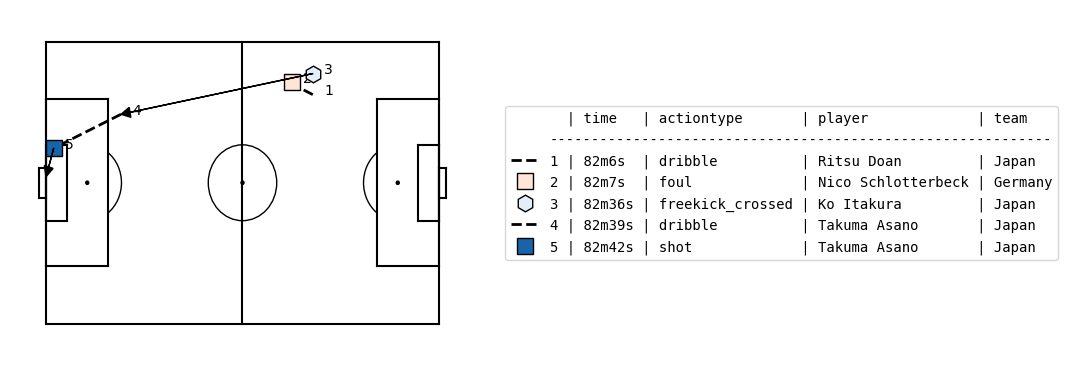

In [11]:
import matplotsoccer

# Select the 5 actions preceding the 2-0
shot = 1957
a = actions[shot-4:shot+1].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)